# AEROSP 520 Compressible Flow: Homework 3
Jason Chen

## Problem 1
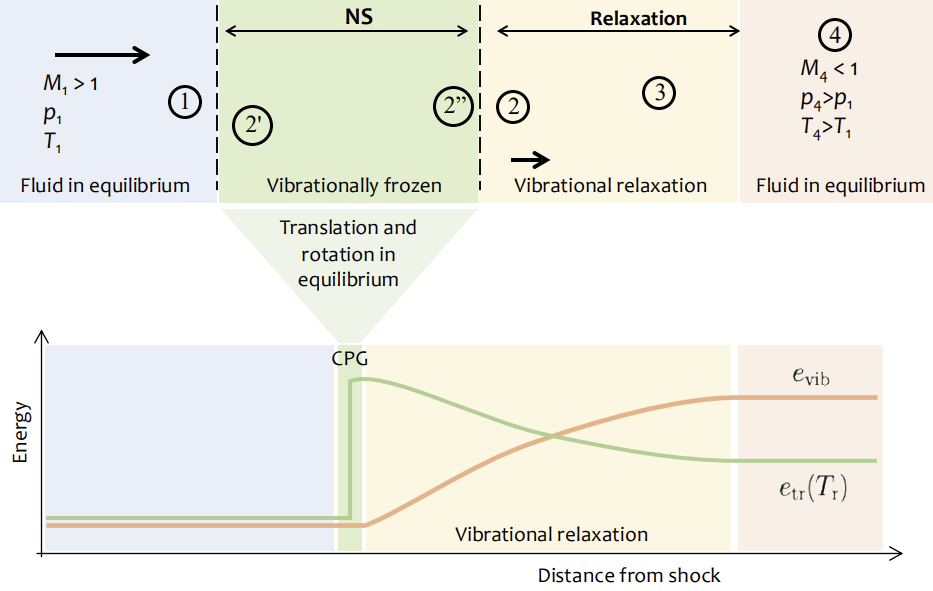

In this problem, we're asked to model the relaxation region after a normal shock using the continuity equations and the relaxation timescale model as proposed by Millikan and White (1963). The continuity equations in differential form are:
$$
\rho \frac{du}{dx} + u \frac{d\rho}{dx} = 0
$$
$$
\frac{dp}{dx} + \rho u \frac{du}{dx} = 0
$$
$$
\frac{dh}{dx} - \frac{1}{\rho} \frac{dp}{dx} = \frac{d(h^{*}+\frac{1}{2}u^2)}{dx} + \frac{d e_{vib}}{dx} = 0
$$
Enthalpy by definition is:
$$
h = e_{tr} + e_{rot} + e_{vib} + RT 
$$
For the vibrationally frozen enthalpy and given that our mixture is made of linear diatomic molecules:
$$
h^{*} = e^{*} + pv = e_{tr} + e_{rot} + RT = \frac{3}{2}RT + \frac{2}{2}RT + RT = \frac{7}{2}RT
$$
The Landau-Teller model for vibrational relaxation when applied to a 1D steady problem (re-expressed using the total derivative as shown in lecture) is:
$$
u \frac{d e_{vib}}{dx} = - \frac{e_{vib} - e^{*}_{vib}}{\tau_v(p, T)}
$$
where $e_{vib}$ is the actual amount of energy in the vibrational mode, $e^{*}_{vib}$ is the apparent vibrational energy (if evaluated at the local temperature, $T_{tr}$):
$$
e^{*}_{vib}(T_{tr}) = \frac{R\Theta_v}{e^{\Theta_v/T_r}-1}
$$
$\tau_v$ is the timescale from Millikan and White. The result of the Millikan and White paper is an empirically derived relationship:
$$
\ln(p\tau_v) = \left( 1.16 \times 10^{-3} \right) \mu^{\frac{1}{2}} \Theta_v^{\frac{4}{3}} \left( T^{-\frac{1}{3}} - 0.015\mu^{\frac{1}{4}} \right) - 18.42
$$
where $\mu$ is the reduced mass of the colliding pair, which given each has a molecular mass $m_1$ and $m_2$:
$$
\mu = \frac{m_1 m_2}{m_1 + m_2}
$$
$\Theta_v$ is the characteristic vibrational temperature, representing the quantum spacing of an internal mode (like vibration). For example: $\Theta_v = 3390 \textrm{ K}$ for $N_2$ and $\Theta_v = 2270 \textrm{ K}$ for $O_2$. Combining the energy equations:
$$
\left(
\frac{5}{2}u - \frac{7}{2}RT_{\mathrm{tr}}
\right)
\frac{du}{dx}
=
\sum_{i=1}^{N}
y_i\,
\frac{
e^{*}_{\mathrm{vib},i}(T_{\mathrm{tr}})
-
e_{\mathrm{vib},i}
}{
u\,\bar{\tau_i}(p,T)
}
$$
where $y_i$ is the mass fraction of species $i$ in the mixture.
The problem statement tells us to perform this relaxation assuming the medium is air, which is 21% $O_2$ and 79% $N_2$ by volume. This means that all possible collisions are between $O_2$-$O_2$, $N_2$-$N_2$, and $N_2$-$O_2$, and these processes occur at different rates. So for a species colliding with all possible partners, we can define an average relaxation time $\bar{\tau_i}$:
$$
\frac{1}{\bar{\tau_i}} = \sum_{j=1}^{N}{\frac{X_i}{\tau_{i-j}}}
$$
We will use the first order upwind finite difference scheme to break up the differentials:
$$
\frac{d\phi}{dx} = \frac{\phi_{k+1} - \phi_{k}}{\Delta x}
$$
This means that, for example, the Landau-Teller equation can be rewritten as:
$$
e_{vib,i,k+1} = \left(\frac{e^{*}_{vib,i,k} - e_{vib,i,k}}{u \tau_i(p, T)}\right) \Delta x + e_{vib,i,k}
$$

Thus, we can solve the problem in this order:
1. Use Landau-Teller for each species to find the new $e_{vib}$ at state $k+1$ (we know the initial vibrational energy postshock from the preshock condition, since the mode is frozen across the NS)
2. Get $\bar{\tau}$ for each species as a function of its collisions with other species
3. Solve numerically for the new velocity $u_{k+1}$
4. Use continuity to solve for $\rho_{k+1}$
5. Use continuity to solve for $p_{k+1}$


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# First, establish mass fractions, mole fractions, and mixture properties
x_O2 = 0.21
x_N2 = 0.79
M_O2 = 32.00e-3
M_N2 = 28.01e-3
M_mix = x_O2 * M_O2 + x_N2 * M_N2
# Mass fractions
y_O2 = x_O2 * M_O2 / M_mix
y_N2 = x_N2 * M_N2 / M_mix
R_univ = 8.3145
R_O2 = R_univ / M_O2
R_N2 = R_univ / M_N2
R_mix = R_univ / M_mix
gamma_star = 7/5
theta_v_O2 = 2270
theta_v_N2 = 3390
mu_O2, mu_N2 = 16, 14
mu_N2_O2 = (mu_N2 * mu_O2) / (mu_N2 + mu_O2)

def get_thermalized_e_vib(theta_v, R, T_v):
    return (theta_v * R)/(np.exp(theta_v/T_v) - 1)

def get_tau_i_j(T_tr, p, mu, theta_v):
    return (np.exp(1.16e-3 * mu**(1/2) * theta_v**(4/3) * (T_tr**(-1/3) - 0.015 * mu**(1/4)) - 18.42)) / (p/101325)

def solve_relaxation(M1, end_x, dx=2e-7):
    # Inlet conditions
    p1 = 1.2e3
    T1 = 227
    a1 = np.sqrt(gamma_star * R_mix * T1)
    u1 = M1 * a1
    rho1 = p1 / (R_mix * T1)
    # Across the NS, vibrationally frozen, equilibrium translational and rotational modes
    p2 = p1 * (1 + 2 * gamma_star * (M1**2 - 1)/(gamma_star + 1))
    rho2 = rho1 * ((gamma_star+1) * M1**2)/(2 + (gamma_star-1) * M1**2)
    u2 = u1 * (2 + (gamma_star - 1) * M1**2) / ((gamma_star + 1) * M1**2)
    T2 = p2 / (rho2 * R_mix)
    # Set up data collection
    x_range = np.arange(0, end_x, dx)
    e_vib_o2 = np.zeros(len(x_range))
    e_vib_n2 = np.zeros(len(x_range))
    e_vib_mix = np.zeros(len(x_range))
    u = np.zeros(len(x_range))
    rho = np.zeros(len(x_range))
    p = np.zeros(len(x_range))
    T = np.zeros(len(x_range))
    # Input initial conditions
    e_vib_o2[0] = get_thermalized_e_vib(theta_v_O2, R_O2, T1)
    e_vib_n2[0] = get_thermalized_e_vib(theta_v_N2, R_N2, T1)
    e_vib_mix[0] = e_vib_o2[0] * y_O2 + e_vib_n2[0] * y_N2
    u[0], rho[0], p[0], T[0] = u2, rho2, p2, T2
    for i in range(1, len(x_range)):
        T_prev, p_prev = T[i-1], p[i-1]
        # Get relaxation rates at the current temperature
        tau_o2_o2 = get_tau_i_j(T_prev, p_prev, mu_O2, theta_v_O2)
        tau_o2_n2 = get_tau_i_j(T_prev, p_prev, mu_N2_O2, theta_v_O2)
        tau_bar_o2 = (x_O2/tau_o2_o2 + x_N2/tau_o2_n2)**-1
        tau_n2_n2 = get_tau_i_j(T_prev, p_prev, mu_N2, theta_v_N2)
        tau_n2_o2 = get_tau_i_j(T_prev, p_prev, mu_N2_O2, theta_v_N2)
        tau_bar_n2 = (x_N2/tau_n2_n2 + x_O2/tau_n2_o2)**-1
        # Compute new vibrational energies using Landau-Teller and forward Euler integration
        e_vib_star_o2 = get_thermalized_e_vib(theta_v_O2, R_O2, T_prev)
        e_vib_o2[i] = ((e_vib_star_o2 - e_vib_o2[i-1])/(u[i-1] * tau_bar_o2)) * dx + e_vib_o2[i-1]
        e_vib_star_n2 = get_thermalized_e_vib(theta_v_N2, R_N2, T_prev)
        e_vib_n2[i] = ((e_vib_star_n2 - e_vib_n2[i-1])/(u[i-1] * tau_bar_n2)) * dx + e_vib_n2[i-1]
        e_vib_mix[i] = e_vib_o2[i] * y_O2 + e_vib_n2[i] * y_N2
        rhs_rate_o2 = ((e_vib_star_o2 - e_vib_o2[i-1])/(u[i-1] * tau_bar_o2)) * y_O2
        rhs_rate_n2 = ((e_vib_star_n2 - e_vib_n2[i-1])/(u[i-1] * tau_bar_n2)) * y_N2
        du_dx = (rhs_rate_o2 + rhs_rate_n2)/((5/2)*u[i-1] - (7/2)*R_mix*T_prev)
        # Integrate forwards to get new flow velocity
        u[i] = du_dx * dx + u[i-1]
        rho[i] = (-(rho[i-1]/u[i-1]) * du_dx) * dx + rho[i-1]
        p[i] = (-(rho[i-1]*u[i-1]) * du_dx) * dx + p[i-1]
        T[i] = p[i] / (rho[i] * R_mix)
    return x_range, e_vib_o2, e_vib_n2, e_vib_mix, u, rho, p, T, T2, p2, u2

data = solve_relaxation(M1=10, end_x=0.01)
x_range, e_vib_o2, e_vib_n2, e_vib_mix, u, rho, p, T, T2, p2, u2 = data
T_norm = 1+(np.divide(T, T2)-1)*5e2
p_norm = 1+(np.divide(p, p2)-1)*5e2
u_norm = 1+(np.divide(u, u2)-1)*5e2


### Part (a)
The numerical solution was found above, such that if we define equilibrium after the shock as once $e_{vib}$ reaches 1% of its equilibrium value, we see that:

In [38]:
print('Relaxation equilibrium solution:')
print(f'Temperature: {T_norm[-1]*T2:.2f} K | Pressure: {p_norm[-1]*p2:.1f} Pa | Velocity: {u_norm[-1]*u2:.2f} m/s')
print('CPG solution:')
print(f'Temperature: {T2:.2f} K | Pressure: {p2:.1f} Pa | Velocity: {u2:.2f} m/s')

Relaxation equilibrium solution:
Temperature: 3948.78 K | Pressure: 145263.1 Pa | Velocity: 431.22 m/s
CPG solution:
Temperature: 4627.96 K | Pressure: 139800.0 Pa | Velocity: 529.63 m/s


## Part (b)
Find the relaxation region length $\Delta x$ defined as the length from the normal shock required for the vibrational
energy to be within 1% of its final equilibrium value. Plot $\Delta x$ as a function of $M_1$ for the given initial
conditions in the range $1 < M_1 < 10$.

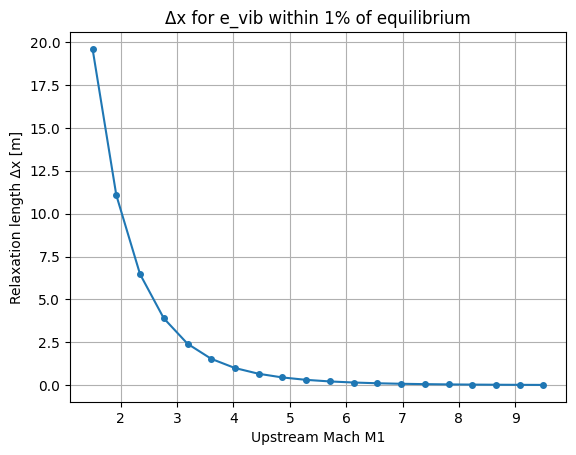

In [68]:
n = 20
end_x = 50
dx = 1e-4
delta_x_list = np.zeros(n)

for k, M in enumerate(np.linspace(4.5, 9.5, n)):
    x_range, e_vib_o2, e_vib_n2, e_vib_mix, u, rho, p, T, T2, p2, u2 = solve_relaxation(M, end_x, dx=dx)
    # Threshold: within 1% of equilibrium
    tol = 0.01 * np.abs(e_vib_mix[-1])
    # Find first index where mixture vibrational energy is within tolerance
    idx = np.where(np.abs(e_vib_mix - e_vib_mix[-1]) <= tol)[0]
    delta_x = x_range[idx[0]]
    # print(f'Mach {M:.2f} | Relaxation length Δx = {delta_x*1e3:.1f} mm')
    delta_x_list[k] = delta_x

plt.figure()
plt.plot(np.linspace(1.5, 9.5, n), delta_x_list, '-o', markersize=4)
plt.xlabel('Upstream Mach M1')
plt.ylabel('Relaxation length Δx [m]')
plt.title('Δx for e_vib within 1% of equilibrium')
plt.grid(True)
plt.show()

### Part (c)

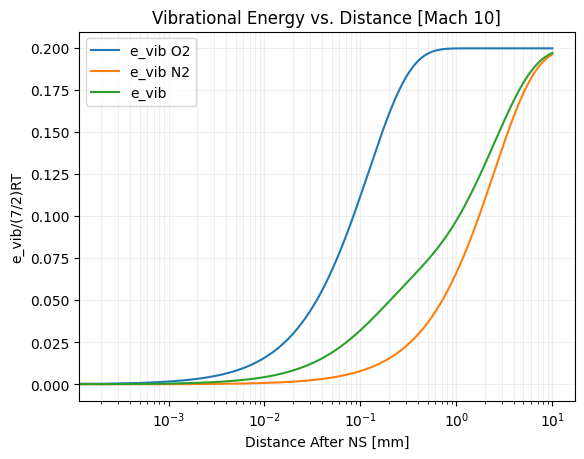

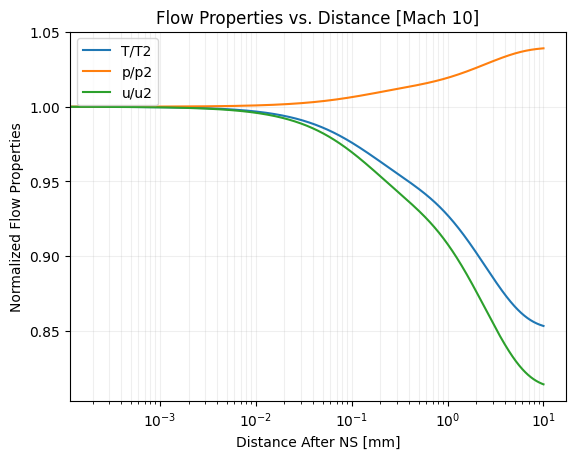

In [69]:
data = solve_relaxation(M1=10, end_x=0.01)
x_range, e_vib_o2, e_vib_n2, e_vib_mix, u, rho, p, T, T2, p2, u2 = data

plt.figure()
plt.plot(x_range * 1e3, np.divide(e_vib_o2, (7/2)*R_mix*T), linewidth=1.5, label='e_vib O2')
plt.plot(x_range * 1e3, np.divide(e_vib_n2, (7/2)*R_mix*T), linewidth=1.5, label='e_vib N2')
plt.plot(x_range * 1e3, np.divide(e_vib_mix, (7/2)*R_mix*T), linewidth=1.5, label='e_vib')
plt.xscale('log')
plt.xlabel('Distance After NS [mm]')
plt.ylabel('e_vib/(7/2)RT')
plt.title('Vibrational Energy vs. Distance [Mach 10]')
plt.legend()
plt.grid(which='both', axis='both', linestyle='-', alpha=0.2)
plt.show()

plt.figure()
plt.plot(x_range * 1e3, T_norm, linewidth=1.5, label='T/T2')
plt.plot(x_range * 1e3, p_norm, linewidth=1.5, label='p/p2')
plt.plot(x_range * 1e3, u_norm, linewidth=1.5, label='u/u2')
plt.xscale('log')
plt.xlabel('Distance After NS [mm]')
plt.ylabel('Normalized Flow Properties')
plt.title('Flow Properties vs. Distance [Mach 10]')
plt.legend()
plt.grid(which='both', axis='both', linestyle='-', alpha=0.2)
plt.show()

### Part (d)

We can see pretty clearly that the equilibrium distance changes exponentially with decreasing Mach number, meaning that at lower Mach numbers the relaxation distance is large and therefore we must model the process instead of treating it like a CPG. Fortunately, because the strength of the shock (and therefore change in state properties relative to the postshock CPG jump relations) is inversely related to the equilibrium distance, it means that a CPG solution is "less off" for lower Mach numbers.

To answer the question when does vibrational non-equilibrium become important: it really depends. At low Mach numbers while still in the bulk of the atmosphere, the difference in state variables computed will not necessarily affect vehicle design in a major way (imagine a Mach 2 passenger airliner). However for high hypersonics (e.g. on re-entry), the relaxation process is very important since the process evolves over the course of tens of millimeters, which can still affect heat sheilding and inlet design.